<a href="https://colab.research.google.com/github/ShohamWeiss/Statistics/blob/master/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Set Up

In [72]:
from google.colab import files
import pandas as pd
import statsmodels as stat
import random
import numpy as np
import datetime
import io

In [73]:
uploadedFile = files.upload()

Saving TempTimeSeries.csv to TempTimeSeries (2).csv


In [74]:
def toDate(x):
  x = str(x)
  return x[0:4] + "-" + x[4:] + "-01"

In [163]:
df = pd.read_csv(io.BytesIO(uploadedFile['TempTimeSeries.csv']))
df.Year = pd.to_datetime(df.Year.apply(toDate))
df = df.set_index(df.Year)
df = df.drop(['Year'], axis=1)
df['Partial'] = np.where(df.index < datetime.datetime(2019,1,1), df.Value, np.nan)
df

,Value,Partial
Year,,
2015-01-01,1.88,1.88
2015-02-01,-0.49,-0.49
2015-03-01,1.87,1.87
2015-04-01,1.25,1.25
2015-05-01,1.09,1.09
...,...,...
2020-02-01,1.20,NaN
2020-03-01,1.38,NaN
2020-04-01,0.09,NaN


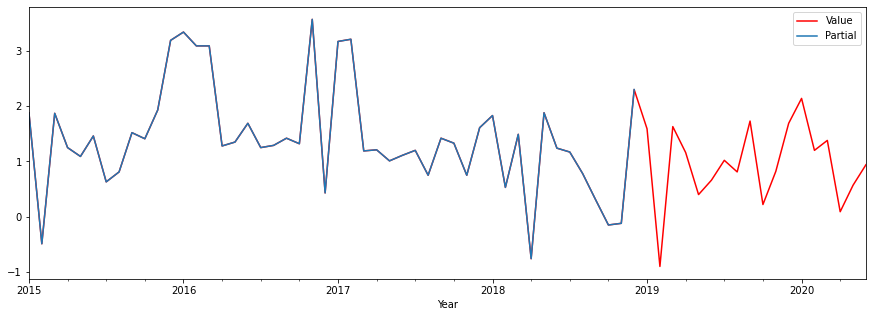

In [153]:
df.plot(style=['r'],figsize=(15,5))

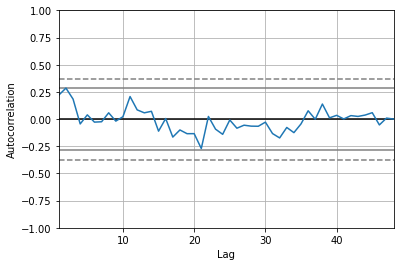

In [162]:
data = df.Partial[df.Partial.notnull()]
toPredict = df.Value[df.Partial.isnull()]
pd.plotting.autocorrelation_plot(data)

# AutoCorrelation Model

In [155]:
from statsmodels.tsa.ar_model import  AutoReg
model = AutoReg(data.to_list(), lags=20, trend='t')
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   48
Model:                    AutoReg(20)   Log Likelihood                 -24.262
Method:               Conditional MLE   S.D. of innovations              0.576
Date:                Thu, 06 Aug 2020   AIC                              0.467
Time:                        22:09:04   BIC                              1.513
Sample:                            20   HQIC                             0.787
                                   48                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend         -0.0147      0.013     -1.139      0.255      -0.040       0.011
y.L1          -0.4158      0.210     -1.985      0.047      -0.826      -0.005
y.L2          -0.0848      0.211     -0.401      0.6

In [156]:
x = model_fit.predict(data.size, data.size + toPredict.size - 1)
print(toPredict.to_list(), len(toPredict.to_list()))
print(x, len(x))

[1.59, -0.9, 1.63, 1.16, 0.4, 0.66, 1.02, 0.81, 1.73, 0.22, 0.82, 1.69, 2.14, 1.2, 1.38, 0.09, 0.57, 0.94] 18
[ 0.75411719  1.26767145 -1.07569814 -0.09490514  0.79970849  0.13590575
  1.98850143 -0.81254017 -0.14952623 -1.50845323  0.93137189  0.79542682
  0.97869261 -0.44041831 -2.09599863 -0.05664455 -0.85400162  2.25217564] 18


In [157]:
dfprediction = pd.DataFrame({"Prediction": x, "Date": toPredict.index.to_list()})
dfprediction = dfprediction.set_index(dfprediction.Date)
dfprediction = dfprediction.drop(['Date'], axis=1)
dfprediction.head(2)

,Prediction
Date,
2019-01-01,0.754117
2019-02-01,1.267671


In [159]:
df2 = df.join(dfprediction)
df2.tail(20)

,Value,Partial,Prediction
Year,,,
2018-11-01,-0.12,-0.12,NaN
2018-12-01,2.30,2.30,NaN
2019-01-01,1.59,NaN,0.754117
2019-02-01,-0.90,NaN,1.267671
2019-03-01,1.63,NaN,-1.075698
2019-04-01,1.16,NaN,-0.094905
2019-05-01,0.40,NaN,0.799708
2019-06-01,0.66,NaN,0.135906
2019-07-01,1.02,NaN,1.988501


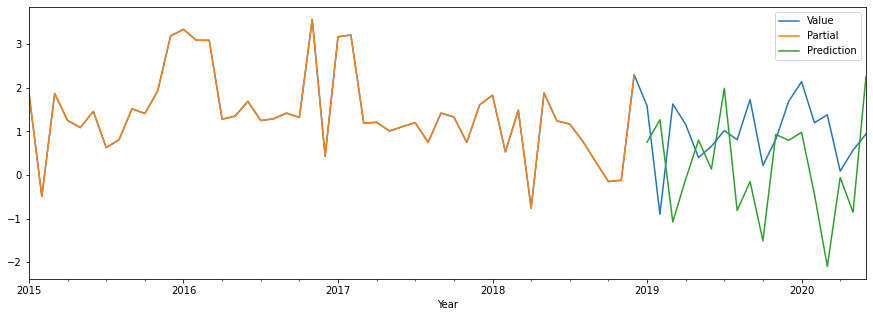

In [160]:
df2.plot(figsize=(15,5))

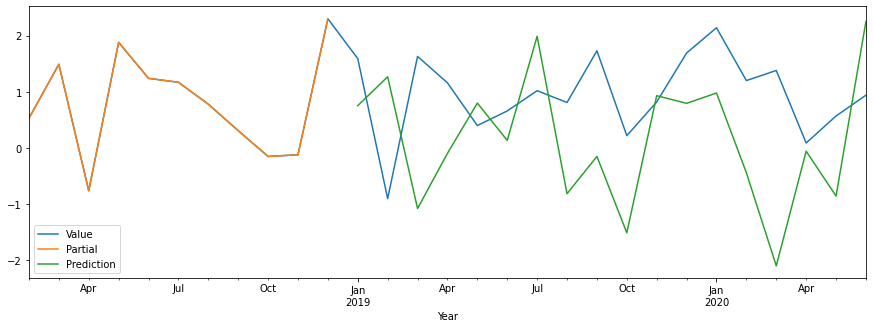

In [161]:
df2[df.index > datetime.datetime(2018,1,1)].plot(figsize=(15,5))

# Moving Average Model

In [188]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(data.to_list(), order=(0,1))
model_fit = model.fit(disp=False)
MAprediction = model_fit.predict(len(data), len(data) + len(toPredict) - 1)
print(MAprediction, len(MAprediction))
print(toPredict.to_list(), len(toPredict))

[1.5942253  1.42538096 1.42538096 1.42538096 1.42538096 1.42538096
 1.42538096 1.42538096 1.42538096 1.42538096 1.42538096 1.42538096
 1.42538096 1.42538096 1.42538096 1.42538096 1.42538096 1.42538096] 18
[1.59, -0.9, 1.63, 1.16, 0.4, 0.66, 1.02, 0.81, 1.73, 0.22, 0.82, 1.69, 2.14, 1.2, 1.38, 0.09, 0.57, 0.94] 18


In [189]:
dfprediction = pd.DataFrame({"Prediction": MAprediction, "Date": toPredict.index.to_list()})
dfprediction = dfprediction.set_index(dfprediction.Date)
dfprediction = dfprediction.drop(['Date'], axis=1)
dfprediction.head(2)

,Prediction
Date,
2019-01-01,1.594225
2019-02-01,1.425381


In [190]:
df2 = df.join(dfprediction)
df2.tail(20)

,Value,Partial,Prediction
Year,,,
2018-11-01,-0.12,-0.12,NaN
2018-12-01,2.30,2.30,NaN
2019-01-01,1.59,NaN,1.594225
2019-02-01,-0.90,NaN,1.425381
2019-03-01,1.63,NaN,1.425381
2019-04-01,1.16,NaN,1.425381
2019-05-01,0.40,NaN,1.425381
2019-06-01,0.66,NaN,1.425381
2019-07-01,1.02,NaN,1.425381


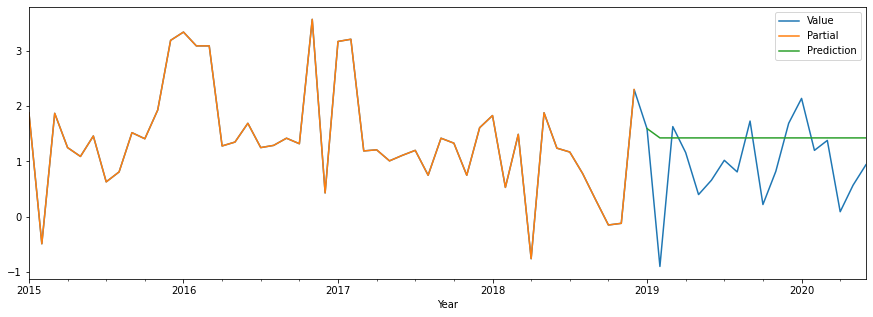

In [191]:
df2.plot(figsize=(15,5))

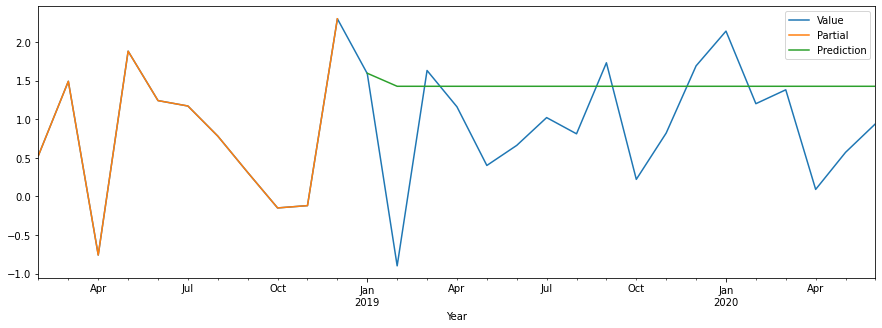

In [192]:
df2[df.index > datetime.datetime(2018,1,1)].plot(figsize=(15,5))

# ARMA Model

In [203]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(data.to_list(), order=(10,5))
model_fit = model.fit(disp=False)
ARMAprediction = model_fit.predict(len(data), len(data) + len(toPredict) - 1)
print(MAprediction, len(MAprediction))
print(toPredict.to_list(), len(toPredict))

[1.09825979 2.25599684 1.69307994 1.62644426 1.50389172 1.20355382
 1.36798339 1.53362396 1.51300785 1.4272754  1.65960442 1.29695711
 1.50812912 1.33829724 1.38616881 1.4645898  1.39497421 1.45121446] 18
[1.59, -0.9, 1.63, 1.16, 0.4, 0.66, 1.02, 0.81, 1.73, 0.22, 0.82, 1.69, 2.14, 1.2, 1.38, 0.09, 0.57, 0.94] 18


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [204]:
dfprediction = pd.DataFrame({"Prediction": ARMAprediction, "Date": toPredict.index.to_list()})
dfprediction = dfprediction.set_index(dfprediction.Date)
dfprediction = dfprediction.drop(['Date'], axis=1)
dfprediction.head(2)

,Prediction
Date,
2019-01-01,0.984437
2019-02-01,2.394721


In [205]:
df2 = df.join(dfprediction)
df2.tail(20)

,Value,Partial,Prediction
Year,,,
2018-11-01,-0.12,-0.12,NaN
2018-12-01,2.30,2.30,NaN
2019-01-01,1.59,NaN,0.984437
2019-02-01,-0.90,NaN,2.394721
2019-03-01,1.63,NaN,1.465202
2019-04-01,1.16,NaN,1.415108
2019-05-01,0.40,NaN,2.087952
2019-06-01,0.66,NaN,1.156436
2019-07-01,1.02,NaN,1.873935


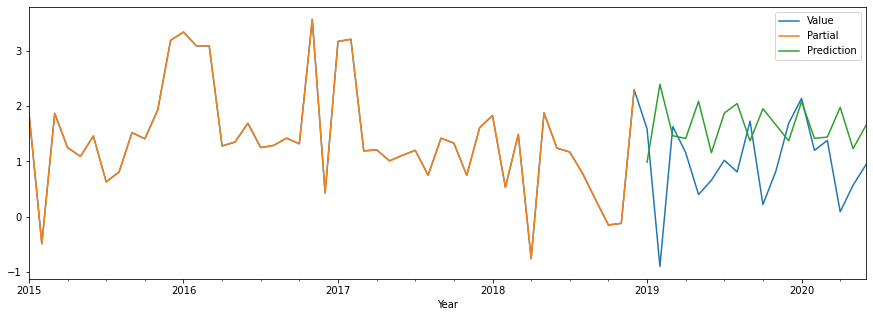

In [206]:
df2.plot(figsize=(15,5))

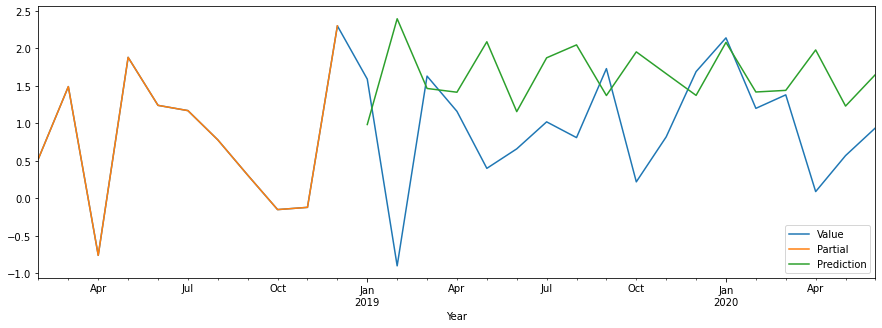

In [207]:
df2[df.index > datetime.datetime(2018,1,1)].plot(figsize=(15,5))

# ARIMA Model

In [214]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data.to_list(), order=(10,2,5))
model_fit = model.fit(disp=False)
ARMAprediction = model_fit.predict(len(data), len(data) + len(toPredict) - 1)
print(MAprediction, len(MAprediction))
print(toPredict.to_list(), len(toPredict))

[1.09825979 2.25599684 1.69307994 1.62644426 1.50389172 1.20355382
 1.36798339 1.53362396 1.51300785 1.4272754  1.65960442 1.29695711
 1.50812912 1.33829724 1.38616881 1.4645898  1.39497421 1.45121446] 18
[1.59, -0.9, 1.63, 1.16, 0.4, 0.66, 1.02, 0.81, 1.73, 0.22, 0.82, 1.69, 2.14, 1.2, 1.38, 0.09, 0.57, 0.94] 18


In [215]:
dfprediction = pd.DataFrame({"Prediction": ARMAprediction, "Date": toPredict.index.to_list()})
dfprediction = dfprediction.set_index(dfprediction.Date)
dfprediction = dfprediction.drop(['Date'], axis=1)
dfprediction.head(2)

,Prediction
Date,
2019-01-01,-5.339891
2019-02-01,4.278188


In [216]:
df2 = df.join(dfprediction)
df2.tail(20)

,Value,Partial,Prediction
Year,,,
2018-11-01,-0.12,-0.12,NaN
2018-12-01,2.30,2.30,NaN
2019-01-01,1.59,NaN,-5.339891
2019-02-01,-0.90,NaN,4.278188
2019-03-01,1.63,NaN,-2.860597
2019-04-01,1.16,NaN,2.062199
2019-05-01,0.40,NaN,0.150774
2019-06-01,0.66,NaN,-1.852546
2019-07-01,1.02,NaN,2.228363


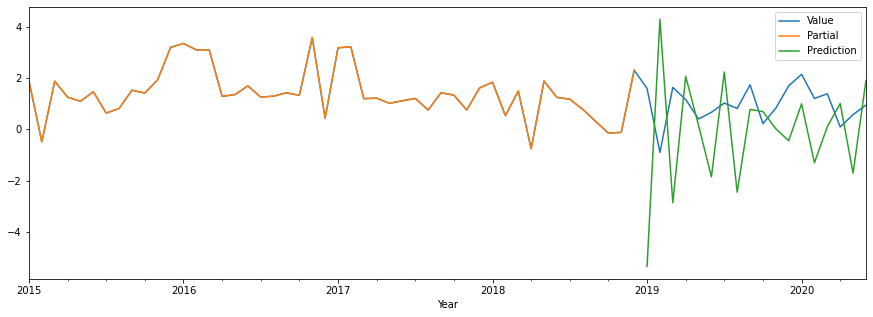

In [217]:
df2.plot(figsize=(15,5))

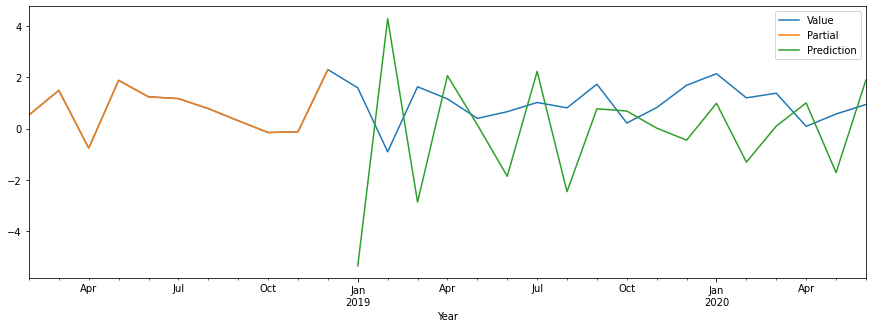

In [218]:
df2[df.index > datetime.datetime(2018,1,1)].plot(figsize=(15,5))